KSCSE2021 GPU Bootcamp AI for Science 
by Hyungon Ryu | NVAITC

# Steady State Flow with Neural Networks

*In aerodynamics related design, analysis and optimization problems, flow fields are simulated using computational fluid
dynamics (CFD) solvers. However, CFD simulation is usually a computationally expensive, memory demanding and
time consuming iterative process. These drawbacks of CFD limit opportunities for design space exploration and forbid
interactive design. We will use a general and flexible approximation model for real-time prediction of non-uniform
steady laminar flow in a 2D domain based on neural networks.*


*This notebook contains a implementation of the paper [Convolutional Neural Networks for Steady Flow Approximation](https://www.autodeskresearch.com/publications/convolutional-neural-networks-steady-flow-approximation). The premise is to learn a mapping from boundary conditions to steady state fluid flow.  It is based on the implementation of [O. Hennigh](https://github.com/loliverhennigh/Steady-State-Flow-With-Neural-Nets)*

## Problem description
Our aim is to predict 2D flow around objects. The input is the boundary around which we want to calculate the flow. 
Here is an example of input data and the corresponding flow that was calculated using the Lattice Boltzmann method ([Mechsys](http://mechsys.nongnu.org/)).
 

We will implement neural networks to predict the steady state flow. We will start with a simple fully connected model, then implement the convolutional model. Finally, we will implement an U-network model based on [this](https://arxiv.org/abs/1710.10352) paper.

## Licensing
This material is released by OpenACC-Standard.org, in collaboration with NVIDIA Corporation, under the Creative Commons Attribution 4.0 International (CC BY 4.0).


## DevOps for Steady State Flow with Neural Networks
- it will take 30 sec to install 

In [ ]:
%%time
%%bash 
apt-get install -y libsm6 libxext6 libxrender-dev git
pip3 install opencv-python==4.1.2.30 pandas seaborn sklearn matplotlib scikit-fmm tqdm h5py gdown

## prepare utility code and dataset
- it will take 2 minutes to download dataset

In [ ]:
!mkdir CFD
!mkdir CFD/source_code
!mkdir CFD/source_code/model
!mkdir CFD/source_code/utils
!mkdir CFD/data

In [ ]:
#@title
%%file dataset.py
import gdown
import os
## CFD TRAIN DATASET
#url = 'https://drive.google.com/uc?id=1VZOPUG6mHsRYG58H_l3_LOPM4N4f9LiZ&export=download'
url = 'https://drive.google.com/u/0/uc?export=download&confirm=jDXw&id=1VZOPUG6mHsRYG58H_l3_LOPM4N4f9LiZ'
output = '/content/CFD/data/train.tfrecords'
gdown.download(url, output, quiet=False)

## CFD TEST DATASET
#url = 'https://drive.google.com/uc?id=1fTo0L0ckqGEeZjLwefBc4S5e28psixle&export=download'
url = 'https://drive.google.com/u/0/uc?export=download&confirm=jDXw&id=1fTo0L0ckqGEeZjLwefBc4S5e28psixle'
output = '/content/CFD/data//test.tfrecords'
gdown.download(url, output, quiet=False)

## CFD CONV_SDF MODEL
#url = 'https://drive.google.com/uc?id=1ObX4jjhv2wkaTfI-ai09SyoOqVP20jAU&export=download'
url = 'https://drive.google.com/u/0/uc?export=download&confirm=jDXw&id=1ObX4jjhv2wkaTfI-ai09SyoOqVP20jAU'
output = '/content/CFD/conv_sdf_model.h5'
gdown.download(url, output, quiet=False)

## CFD CONV MODEL
#url = 'https://drive.google.com/uc?id=1xfw9C7PFrd3e_ef92ZZbRuK__ak7mo0f&export=download'
url = 'https://drive.google.com/u/0/uc?export=download&confirm=jDXw&id=1xfw9C7PFrd3e_ef92ZZbRuK__ak7mo0f'
output = '/content/CFD/conv_model.h5'
gdown.download(url, output, quiet=False)


## CFD TEST Dataset
#url = 'https://drive.google.com/uc?id=1VG9jCTBcERytV7w5bHoaVIZSQOa-AlmU&export=download'
url = 'https://drive.google.com/u/0/uc?export=download&confirm=lR5L&id=1VG9jCTBcERytV7w5bHoaVIZSQOa-AlmU'
output = '/content/CFD/data/computed_car_flow.zip'
gdown.download(url, output, quiet=False)


Overwriting dataset.py


In [ ]:
%%time
!python dataset.py

In [ ]:
#@title
%%file CFD/source_code/utils/data_utils.py

# Copyright (c) 2012, NVIDIA CORPORATION. All rights reserved.
 #
 # Redistribution and use in source and binary forms, with or without
 # modification, are permitted provided that the following conditions
 # are met:
 #  * Redistributions of source code must retain the above copyright
 #    notice, this list of conditions and the following disclaimer.
 #  * Redistributions in binary form must reproduce the above copyright
 #    notice, this list of conditions and the following disclaimer in the
 #    documentation and/or other materials provided with the distribution.
 #  * Neither the name of NVIDIA CORPORATION nor the names of its
 #    contributors may be used to endorse or promote products derived
 #    from this software without specific prior written permission.
 #
 # THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AS IS'' AND ANY
 # EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 # IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
 # PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT OWNER OR
 # CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
 # EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
 # PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
 # PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY
 # OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
 # (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 # OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 

import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import skfmm
from tqdm import tqdm


def eval_input_fn(dataset):
    dataset = dataset.batch(32)
    return dataset.__iter__()

def load_test_data(number):
    filename = "CFD/data/computed_car_flow/sample_{0:d}/fluid_flow_0002.h5".format(number)

    stream_flow = h5py.File(filename)
    v = stream_flow['Velocity_0']
    v = np.array(v).reshape([1,128,256+128,3])[:,:,0:256,0:2]
    b = np.array(stream_flow["Gamma"]).reshape(1, 128, 256 + 128,1)[:,:,0:256,:]
    return (b,v)

def plot_keras_loss(history):
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_boundary(ax, boundary):
    ax.imshow(np.squeeze(boundary), cmap='Greys')


def plot_flow(ax, velocity):
    velocity = np.squeeze(velocity)
    Y, X = np.mgrid[0:velocity.shape[0],0:velocity.shape[1]]
    U = velocity[:,:,0]
    V = velocity[:,:,1]
    strm = ax.streamplot(X, Y, U, V, color=U, linewidth=2, cmap='autumn', integration_direction="both")
    return strm


def plot_flow_data(boundary, velocity, single_plot = False, fig = None, ax = None):
    if single_plot:
        if not (ax or fig):
            fig = plt.figure(figsize = (10,4))
            ax = fig.add_subplot(111)
        plot_boundary(ax, boundary)
        strm = plot_flow(ax, velocity)
        ax.set_title('Input data + simulated flow field')
    else:
        fig = plt.figure(figsize = (16,4))
        ax = fig.add_subplot(121)
        plot_boundary(ax, boundary)
        ax.set_title('Input data X')

        ax = fig.add_subplot(122)
        strm = plot_flow(ax, velocity)
        ax.set_ylim((128,0)) # reverse the y axes to match the boundary plot
        ax.set_title('Simulated flow lines Y')
        ax.set_aspect('equal')

    fig.colorbar(strm.lines)
    return strm

def plot_test_result(x, y, y_hat):
    # Display the simulated and the predicted flow field
    
    # Display field lines
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(221)
    plot_boundary(ax, x)
    strm = plot_flow(ax, y)
    fig.colorbar(strm.lines)
    ax.set_title('Simulated flow')
                
    ax = fig.add_subplot(222)
    plot_boundary(ax, x)
    strm = plot_flow(ax, y_hat)
    fig.colorbar(strm.lines)
    ax.set_title('Flow predicted by NN')
    
    # Show magnitude of the flow
    sflow_plot = np.concatenate([y, y_hat, y-y_hat], axis=2) 
    boundary_concat = np.concatenate(3*[x], axis=2) 

    sflow_plot = np.sqrt(np.square(sflow_plot[:,:,:,0]) + np.square(sflow_plot[:,:,:,1])) # - .05 *boundary_concat[:,:,:,0]
    ax = fig.add_subplot(2,1,2)
    im = ax.imshow(np.squeeze(sflow_plot), cmap='hsv', zorder=1)
    
    # Adding car shape in black
    # We create an RGBA image, setting alpha from boundary_concat
    # This way we can plot the boundary image over the contour plot without the white pixels hiding the contour
    im2 = np.zeros(boundary_concat.shape[1:3] + (4,))
    im2[:, :, 3] = np.squeeze(boundary_concat)
    ax.imshow(im2, cmap='Greys', zorder=2)
    
    ax.set_title('Magnitude of the flow: (left) simulated, (middle) Neural Net prediction,'
                 ' (right) difference')
    fig.colorbar(im)


def calc_sdf(x):
    """ calculates thes signed distance function for a batch of input data
    Arguments:
    x -- nbatch x Heiht x Width [ x 1]
    """
    if x.ndim == 2 or x.ndim == 3: # H x W [ x 1 ] optional single channel
        sdf = skfmm.distance(np.squeeze(0.5-x))
    elif x.ndim == 4: # batched example Nbatch x H x W x 1
        sdf = np.zeros(x.shape)
        for i in range(x.shape[0]):
            sdf[i,:,:,:] = skfmm.distance(np.squeeze(0.5-x[i,:,:,:]))
    else:
        print("Error, invalid array dimension for calc_sdf", x.shape)
        
    return sdf 

def plot_sdf(x, sdf = None, plot_boundary=True):
    x = np.squeeze(x)
    if sdf is None:
        sdf = calc_sdf(x)
    else:
        sdf = np.squeeze(sdf)
    fig = plt.figure(figsize=(16,5))
    ax = plt.subplot(111)
    Y, X = np.mgrid[0:sdf.shape[0],0:sdf.shape[1]]
    cs = ax.contourf(X, Y, sdf, 50, cmap=matplotlib.cm.coolwarm, zorder=1)
    
    ax.set_ylim((128,0))
    fig.colorbar(cs, ax=ax)
    ax.set_aspect('equal')

    if plot_boundary:
        ax.contour(X,Y, sdf, [0], colors='black', zorder=2, linewidths=2)
        # We create an RGBA image, setting alpha from x
        # This way we can plot the boundary image over the contour plot without the white pixels hiding the contour

        #im2 = np.zeros(x.shape + (4,))
        #im2[:, :, 3] = x
        #ax.imshow(im2, cmap='Greys', zorder=2)


def display_flow(sample_number):
    b,v = load_test_data(sample_number)
    plot_flow_data(b,v)

def parse_flow_data(serialized_example):
    shape = (128,256)
    features = {
      'boundary':tf.io.FixedLenFeature([],tf.string),
      'sflow':tf.io.FixedLenFeature([],tf.string)
    }
    parsed_features = tf.io.parse_single_example(serialized_example, features)
    boundary = tf.io.decode_raw(parsed_features['boundary'], tf.uint8)
    sflow = tf.io.decode_raw(parsed_features['sflow'], tf.float32)
    boundary = tf.reshape(boundary, [shape[0], shape[1], 1])
    sflow = tf.reshape(sflow, [shape[0], shape[1], 2])
    boundary = tf.cast(boundary,dtype=tf.float32)
    sflow = tf.cast(sflow,dtype=tf.float32)
    return boundary, sflow

def parse_sdf_flow_data(serialized_example):
    shape = (128,256)
    features = {
      'sdf_boundary':tf.io.FixedLenFeature([],tf.string),
      'sflow':tf.io.FixedLenFeature([],tf.string)
    }
    parsed_features = tf.io.parse_single_example(serialized_example, features)
    boundary = tf.io.decode_raw(parsed_features['sdf_boundary'], tf.float32)
    sflow = tf.io.decode_raw(parsed_features['sflow'], tf.float32)
    boundary = tf.reshape(boundary, [shape[0], shape[1], 2])
    sflow = tf.reshape(sflow, [shape[0], shape[1], 2])
    boundary = tf.cast(boundary,dtype=tf.float32)
    sflow = tf.cast(sflow,dtype=tf.float32)
    return boundary, sflow


# helper function
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


# def create_sdf_file(name):
#     # Set up a dataset for the input data
#     dataset = tf.data.TFRecordDataset('data/'+ name + '.tfrecords')
#
#     # Transform binary data into image arrays
#     dataset = dataset.map(parse_flow_data) 
#
#     # Create an iterator for reading a batch of input and output data
#     iterator = iter(dataset)
#     boundary_t, sflow_t = next(iterator)
#
#
#     # create tf writer
#     record_filename = 'data/' + name + '_sdf.tfrecords'
#
#     writer = tf.io.TFRecordWriter(record_filename)
#
#     shape = [128, 256]
#     
#     if name == 'train':
#         num_images = 3000
#     elif name == 'test' :
#         num_images = 28
#     else:
#         print('error, number of images is not known for ', name)
#         num_images = 1000
#    
#     for i in (range(num_images)):
#             print("*",end='')
#             # read in images    
#             b, s = boundary_t, sflow_t
#  
#             # calculate signed distance function
#             sdf = np.reshape(calc_sdf(b),(shape[0], shape[1], 1))
#         
#             # keep both the boundary (channel 1) and the SDF (channel 2) as input
#             b_sdf = np.concatenate((b,sdf),axis=2)
#     
#             # process frame for saving
#             boundary = np.float32(b_sdf)
#             boundary = boundary.reshape([1,shape[0]*shape[1]*2])
#             boundary = boundary.tostring()
#             sflow = np.float32(s)
#             sflow = sflow.reshape([1,shape[0]*shape[1]*2])
#             sflow = sflow.tostring()
#
#             # create example and write it
#             example = tf.train.Example(features=tf.train.Features(feature={
#             'sdf_boundary': _bytes_feature(boundary),
#             'sflow': _bytes_feature(sflow)}))
#             writer.write(example.SerializeToString())
#             print("/")

def create_sdf_file(name):
    # Set up a dataset for the input data
    dataset = tf.data.TFRecordDataset('CFD/data/'+ name + '.tfrecords')

    # Transform binary data into image arrays
    dataset = dataset.map(parse_flow_data) 

    # Create an iterator for reading a batch of input and output data
    iterator = iter(dataset)


    # create tf writer
    record_filename = 'CFD/data/' + name + '_sdf.tfrecords'

    writer = tf.io.TFRecordWriter(record_filename)

    shape = [128, 256]
    
    if name == 'train':
        num_images = 3000
    elif name == 'test' :
        num_images = 28
    else:
        print('error, number of images is not known for ', name)
        num_images = 1000
   
    for i in tqdm(range(num_images)):
        try:
            # read in images
            boundary_t, sflow_t = next(iterator)
            b, s = boundary_t, sflow_t
 
            # calculate signed distance function
            sdf = np.reshape(calc_sdf(b),(shape[0], shape[1], 1))
        
            # keep both the boundary (channel 1) and the SDF (channel 2) as input
            b_sdf = np.concatenate((b,sdf),axis=2)
    
            # process frame for saving
            boundary = np.float32(b_sdf)
            boundary = boundary.reshape([1,shape[0]*shape[1]*2])
            boundary = boundary.tostring()
            sflow = np.float32(s)
            sflow = sflow.reshape([1,shape[0]*shape[1]*2])
            sflow = sflow.tostring()

            # create example and write it
            example = tf.train.Example(features=tf.train.Features(feature={
            'sdf_boundary': _bytes_feature(boundary),
            'sflow': _bytes_feature(sflow)}))
            writer.write(example.SerializeToString())
        except tf.errors.OutOfRangeError:
            print('Finished writing into', record_filename)
            print('Read in ', idx, ' images')
            break



Overwriting CFD/source_code/utils/data_utils.py


In [ ]:
#@title
%%file CFD/source_code/model/flow_architecture.py

# Copyright (c) 2012, NVIDIA CORPORATION. All rights reserved.
# 
 # Redistribution and use in source and binary forms, with or without
 # modification, are permitted provided that the following conditions
 # are met:
 #  * Redistributions of source code must retain the above copyright
 #    notice, this list of conditions and the following disclaimer.
 #  * Redistributions in binary form must reproduce the above copyright
 #    notice, this list of conditions and the following disclaimer in the
 #    documentation and/or other materials provided with the distribution.
 #  * Neither the name of NVIDIA CORPORATION nor the names of its
 #    contributors may be used to endorse or promote products derived
 #    from this software without specific prior written permission.
 #
 # THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AS IS'' AND ANY
 # EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
 # IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
 # PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT OWNER OR
 # CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
 # EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
 # PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
 # PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY
 # OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
 # (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 # OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""functions used to construct different architectures
"""

# Import Necessary Libraries

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D , Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

def int_shape(x):
  return x.get_shape().as_list()

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(values=[x, -x], axis=axis))

def set_nonlinearity(name):
  if name == 'concat_elu':
    return concat_elu
  elif name == 'elu':
    return tf.nn.elu
  elif name == 'concat_relu':
    return tf.nn.crelu
  elif name == 'relu':
    return tf.nn.relu
  else:
    raise('nonlinearity ' + name + ' is not supported')

def _activation_summary(x):
  """Helper to create summaries for activations.
  Creates a summary that provides a histogram of activations.
  Creates a summary that measure the sparsity of activations.
  Args:
    x: Tensor
  Returns:
    nothing
  """
  tensor_name = x.op.name
  tf.summary.histogram(tensor_name + '/activations', x)
  tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

def _variable(name, shape, initializer):
  """Helper to create a Variable.
  Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
  Returns:
    Variable Tensor
  """
  # getting rid of stddev for xavier ## testing this for faster convergence
  var = tf.Variable(name=name, initial_value=initializer(shape=shape))
  return var

def conv_layer(inputs, kernel_size, stride, num_features, idx, nonlinearity=None):

    conv = Conv2D(num_features, kernel_size, strides=(stride, stride), padding='same')(inputs)
    
    if nonlinearity is not None:
      conv = nonlinearity(conv)
    return conv

def transpose_conv_layer(inputs, kernel_size, stride, num_features, idx, nonlinearity=None):
        
    conv = Conv2DTranspose(num_features, kernel_size, strides=(stride, stride), padding='same')(inputs)
    
    if nonlinearity is not None:
      conv = nonlinearity(conv)

    return conv

def fc_layer(inputs, hiddens, idx, nonlinearity=None, flat = False):
    input_shape = inputs.get_shape().as_list()
    if flat:
        dim = input_shape[1]*input_shape[2]*input_shape[3]
        inputs_processed = tf.reshape(inputs, [-1,dim])
    else:
        dim = input_shape[1]
        inputs_processed = inputs
    output_biased = Dense(hiddens, input_dim=dim)(inputs_processed)
    if nonlinearity is not None:
      output_biased = nonlinearity(ouput_biased)
    return output_biased
def nin(x, num_units, idx):
    """ a network in network layer (1x1 CONV) """
    s = int_shape(x)
    x = tf.keras.layers.Reshape((np.prod(s[1:-1]),s[-1]))(x)
    x = fc_layer(x, num_units, idx) # fully connected layer
    return tf.keras.layers.Reshape(tuple(s[1:-1]+[num_units]))(x)

Writing CFD/source_code/model/flow_architecture.py


## Approaching the Problem
As mentioned in the Introduction to Deep Learning notebook we will follow the same steps in this notebook as well:
- Data
- Tasks
- Model
- Loss
- Learning
- Evaluation

## Data and Task
Like we saw in the previous notebook, our input and output data are as follows :

This Simulated Flow lines were calculated using Lattice Boltzmann method (Mechsys).

Let us import our dataset and see some of the input output pairs :

In [ ]:
# Importing Necessary Libaries 
from __future__ import print_function

import sys
sys.path.append('/content/CFD/source_code')

import numpy as np
import utils.data_utils as data_utils
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import math
import matplotlib.pyplot as plt

import time

import importlib
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

The input dataset is stored as a `TFRecords` file which is suitable for storing large datasets which cannot be loaded into memory and Tensorflow takes batches of data to optimize our data pipelining process.

In [ ]:
# Set up our dataset
dataset = tf.data.TFRecordDataset('CFD/data/train.tfrecords')
# Transform binary data into image arrays
dataset = dataset.map(data_utils.parse_flow_data) 

batched_dataset = dataset.batch(32, drop_remainder=True)

# Create an iterator for reading a batch of input and output data
iterator = iter(batched_dataset)
boundary, vflow = next(iterator)

print('Input shape:', boundary.shape.as_list())
print('Output shape:', vflow.shape.as_list())

Input shape: [32, 128, 256, 1]
Output shape: [32, 128, 256, 2]


We have set up a batch of 32 images with 128x256 resolution. The input data has only 1 channel (last dimension), which describes the boundary. The output data has 2 channels the x and y velocity component of the flow.

Let us now display some of the training examples. Feel free to change `plot_idx`, and try plotting into a single figure.

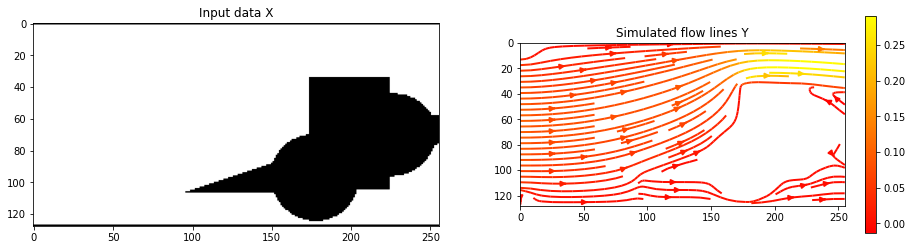

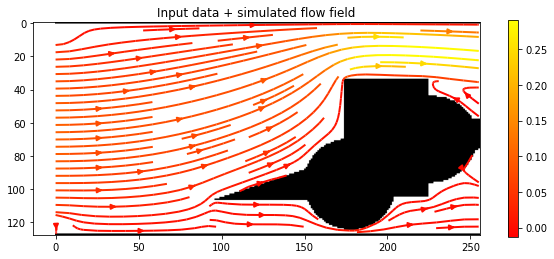

In [ ]:
plot_idx = 10 # set it between 0-31

data_utils.plot_flow_data(boundary[plot_idx,:,:,:], vflow[plot_idx,:,:,:])

# You can plot the input and output data into a single figure
data_utils.plot_flow_data(boundary[plot_idx,:,:,:], vflow[plot_idx,:,:,:], single_plot=True)


In [ ]:
# How a Boundary is defined ?  

# Running counter over the Input 
from collections import Counter
c = np.array(boundary[plot_idx,:,:,:]).flatten()
c = Counter(c)
c

Counter({0.0: 25378, 1.0: 7390})

From the Input data, we can notice the boundary is defined by 1's and 0's, which is also reported to us by the counter above.

Let us now understand how the flow lines are described.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 4))

ax1.hist(np.array(vflow[plot_idx,:,:,0]).flatten(), density=True, bins=30)
ax1.set_ylabel('Count')
ax1.set_xlabel('Value')
ax1.set_title("X Values")


ax2.hist(np.array(vflow[plot_idx,:,:,1]).flatten(), density=True, bins=30)
ax2.set_ylabel('Count')
ax2.set_xlabel('Value')
ax2.set_title("Y Values")
plt.show()

From the X and Y Values, we can observe that each pixel denotes the velocity vector corresponding to that pixel :

Positive meaning +x or +y  direction and negative meaning the -x or -y  direction respectively.

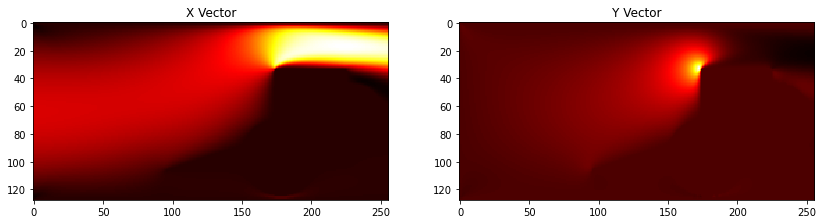

In [ ]:
#Plotting Heatmap of the 2-Channels
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 14))

# Plotting X vector and Y vector separately.

# X Vector 

ax1.imshow(vflow[plot_idx,:,:,0], cmap='hot', interpolation='nearest')
ax1.set_title("X Vector")

# Y Vector

ax2.imshow(-vflow[plot_idx,:,:,1], cmap='hot', interpolation='nearest')
ax2.set_title("Y Vector")
plt.show()

# Model and Loss

We will be building the following Models and benchmarking them as we proceed :

* Simple Fully Connected Networks 
    - *3 Layer Network*
    - *5 Layer Network*
* Convolution Neural Networks 
    - *Binary Boundary*
    - *Signed Distance Function*
* Advanced Networks
    - *Gated Residual Network*
    - *Non-Gated Residual Network*
    
    
There are a variety of functions also discussed in the *Introduction to Deep Learning Notebook*. In this *Task*, we will be using Squared Error Loss.

$$ \mathrm{Loss}(\hat{v}_x, \hat{v}_y, v_x, v_y) = \sum_{i=1}^{n_\mathrm{batch}} 
  \sum_{x=1,y=1}^{nh,nw} \left(\left(v_x^i(x,y) - \hat{v}_x^i(x,y)\right)^2 + 
   \left(v_y^i(x,y) - \hat{v}_y^i(x,y)\right)^2\right) . $$
  
This can be implemented easily using [tf.nn.l2_loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss).

## Training and Evaluation
Epochs: We will be using 25 - 30 epochs. Readers are free to change and play with the values.
Activation Function: We will start with ReLu and improving upon same
Optimizer: We will be using Adam Optimizer with Learning Rate of 0.0001
Test Set: We will be using a set of 28 boundary conditions as part of the out Test set.
Now we have an idea on how to proceed. Let us start building our First Fully Connected Model.

## Building our First Model
### Let's import our data and divide them into training, test and validation sets

In [ ]:
batch_size = 8
dataset_size = 3000   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('CFD/data/train.tfrecords')
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
    training_dataset = training_dataset.repeat()

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    validation_dataset = validation_dataset.repeat()

    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('CFD/data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True).repeat()
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 343 / 32 / 3


## Loss function
Now let us define Loss Function using `tf.nn.l2_loss`

In [ ]:
def loss_image(vflow_hat, vflow):
    '''Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    ''' 
    ### Define the square error loss (~ 1 line of code)
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

## Model
3 - Layer Fully Connected Network :

- Input Layer of Size ( 128 256 1 )
- Hidden Layer of Size ( 256 )
- Output Layer of Size ( 128 256 2 )

In [ ]:
def fully_connected(input):
    # Arguments:
    # input -- input layer for the network, expected shape (?,nh,nw,1)
    # Returns -- predicted flow (?, nh, nw, 2)
    
    nh = K.int_shape(input)[1]
    nw = K.int_shape(input)[2]
    
    # define the hidden layer
    x = layers.Flatten()(input)
    x = layers.Dense(256, activation='relu')(x)
    
    
    ### Define output layer and reshape it to nh x nw x 2. 
    ### (Note that the extra batch dimension is handled automatically by Keras)
    x = layers.Dense(nh*nw*2, activation='relu')(x)
    output = layers.Reshape((nh,nw,2))(x)
    ###
    
    return output

Let us define the input and parameters of our model :

In [ ]:
# Define Inputs and Outputs
input = tf.keras.Input(shape=(128,256,1))
output = fully_connected(input)
# Use Keras Functional API to Create our Model and Define our Optimizer and Loss Function
fc_model = tf.keras.Model(inputs = input, outputs=output)
fc_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
fc_model.summary()

### Let us now train our Model :

In [ ]:
history = fc_model.fit(training_dataset, epochs=30, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches)

In [ ]:
# Let us Plot the train History
data_utils.plot_keras_loss(history)

### Test
We will evaluate the model on the test dataset, and plot some of the results.

In [ ]:
!unzip /content/CFD/data/computed_car_flow.zip -d data

In [ ]:
test_loss = fc_model.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 11ms/step - loss: 94.2974
The loss over the test dataset 94.2973861694336


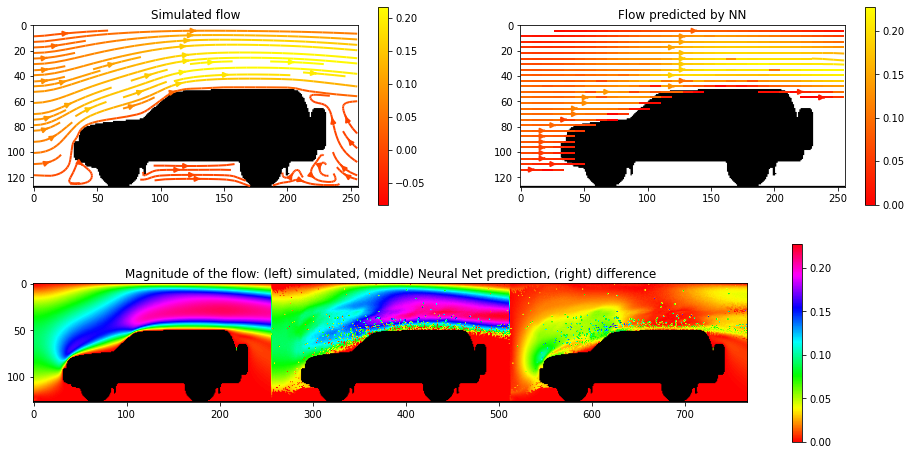

In [ ]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = fc_model.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

We can plot a vertical slice of the velocity field for better comparison

Text(0, 0.5, 'vy')

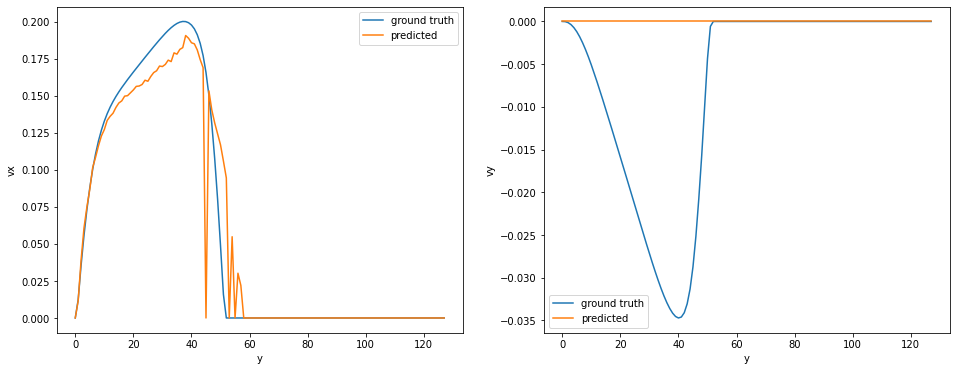

In [ ]:
x_idx=120 # x coordinate for the slice

vx = np.squeeze(vxy[0,:,x_idx,0])                 # test velocity fields
vy = np.squeeze(vxy[0,:,x_idx,1])

vx_hat = np.squeeze(vxy_hat[0,:,x_idx,0])         # predicted velocity field
vy_hat = np.squeeze(vxy_hat[0,:,x_idx,1])

fig = plt.figure(figsize=(16,6))

# plot the x component of the velocity
ax = fig.add_subplot(121)
ax.plot(vx, label='ground truth')
ax.plot(vx_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vx')

# plot the y component of the velocity
ax = fig.add_subplot(122)
ax.plot(vy, label='ground truth')
ax.plot(vy_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vy')

In the upcoming notebook let us define a 5 Layer fully connected network and train it.

# reset the notebook

## Improving our Fully Connected Network
Let us import libraries, dataset and define the Loss function

In [ ]:
# Importing Necessary Libraries 
from __future__ import print_function

import sys
sys.path.append('/content/CFD/source_code')

import numpy as np
import utils.data_utils as data_utils
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import math
import matplotlib.pyplot as plt

import time

import importlib

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

In [ ]:
batch_size = 8
dataset_size = 1500   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('CFD/data/train.tfrecords')
    dataset = dataset.take(dataset_size)
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
    training_dataset = training_dataset.repeat()

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    validation_dataset = validation_dataset.repeat()

    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('CFD/data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True).repeat()
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 155 / 32 / 3


input shape: [8, 128, 256, 1]
output shape: [8, 128, 256, 2]


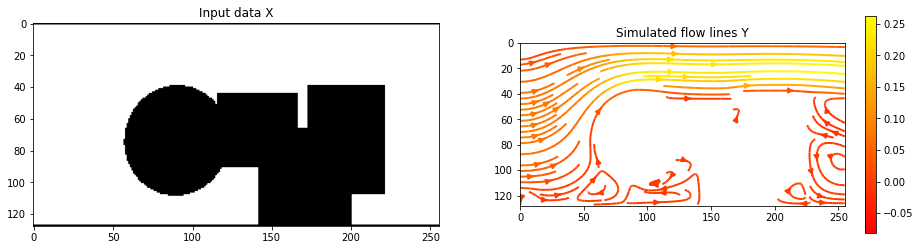

In [ ]:
# Create an iterator for reading a batch of input and output data
iterator = iter(training_dataset)
boundary, vflow = next(iterator)

print('input shape:', boundary.shape.as_list())
print('output shape:', vflow.shape.as_list())

plot_idx = 3 # set it between 0 and batch_size

data_utils.plot_flow_data(boundary[plot_idx,:,:,:], vflow[plot_idx,:,:,:])

In [ ]:
def loss_image(vflow_hat, vflow):
    ''' Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    '''
    ### define the squure error loss (~ 1 line of code)
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

## Model
5 - Layer Fully Connected Network :

- Input Layer of Size ( 128 256 1 )
- Hidden Layer of Size ( 1024 )
- Hidden Layer of Size ( 1024 )
- Hidden Layer of Size ( 1024 )
- Output Layer of Size ( 128 256 2 )

In [ ]:
def fully_connected(input):
    # Arguments:
    # input -- input layer for the network, expected shape (?,nh,nw,1)
    # Returns -- predicted flow (?, nh, nw, 2)
    
    nh = K.int_shape(input)[1]
    nw = K.int_shape(input)[2]
    
    # define the hidden layers
    x = layers.Flatten()(input)
    
     
    ### Add three dense hidden layers with 1024 hidden units each
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    ##
   
    x = layers.Dense(nh*nw*2, activation='relu')(x)
    output = layers.Reshape((nh,nw,2))(x)
    ###
    
    return output

In [ ]:
input = tf.keras.Input(shape=(128,256,1))
output = fully_connected(input)


### Define a new keras model with the above input and output, and compile it with Adam optimizer
fc_model = tf.keras.Model(inputs = input, outputs=output)
fc_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
###
fc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 256, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 65536)             67174400  
                                                                 
 reshape (Reshape)           (None, 128, 256, 2)       0     

In [ ]:
history = fc_model.fit(training_dataset, epochs=30, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches, 
            callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/fc3')])

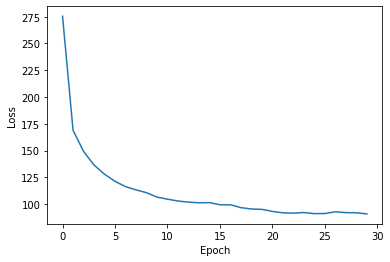

In [ ]:
# Let us Plot the train History
data_utils.plot_keras_loss(history)

## Test
We will evaluate the model on the test dataset, and plot some of the results.

In [ ]:
test_loss = fc_model.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 12ms/step - loss: 79.4024
The loss over the test dataset 79.40239715576172


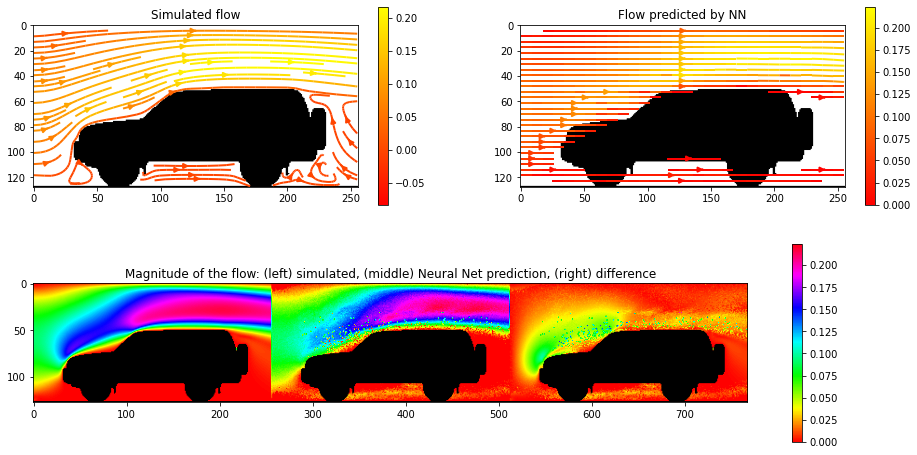

In [ ]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = fc_model.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

We can plot a vertical slice of the velocity field for better comparison

Text(0, 0.5, 'vy')

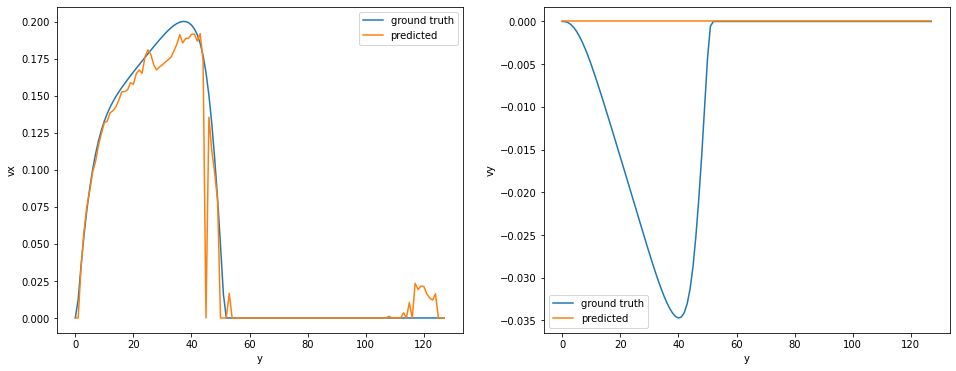

In [ ]:
x_idx=120 # x coordinate for the slice

vx = np.squeeze(vxy[0,:,x_idx,0])                 # test velocity fields
vy = np.squeeze(vxy[0,:,x_idx,1])

vx_hat = np.squeeze(vxy_hat[0,:,x_idx,0])         # predicted velocity field
vy_hat = np.squeeze(vxy_hat[0,:,x_idx,1])

fig = plt.figure(figsize=(16,6))

# plot the x component of the velocity
ax = fig.add_subplot(121)
ax.plot(vx, label='ground truth')
ax.plot(vx_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vx')

# plot the y component of the velocity
ax = fig.add_subplot(122)
ax.plot(vy, label='ground truth')
ax.plot(vy_hat, label='predicted')
ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('vy')

We have bbserved the decrease in the loss function but it is still not sufficient for practical purposes. Let us now define a Convolution Model and see how it performs.

Convolutional model
We will re-create the network from Convolutional Neural Networks for Steady Flow Approximation. Here is an illustration from the paper:

he number of filters and the kernel size are shown below for the conv/deconv operations. The dimension of the feature maps is indicated below in the boxes. The strides are the same as the kernel sizes.

The direct connection between the input and the output layers is just a multiplication that zeros the flow inside the objects.

To Learn about Convolutional Neural Networks and how they work, visit Convolution Neural Network Notebook

## Model
We define the encoding/decoding part separately, and then we combine them.

We will set the parameters for conv2d, and add the fully connected layer

In [ ]:
def conv(input):
    # Define layers to calculate the convolution and FC part of the network
    # Arguments:
    # input -- (?, nh, nw, nc)
    # Returns: (? 1,1,1024)
    
    
    ### Set the number of filters for the first convolutional layer
    x = layers.Conv2D(128, (16,16), strides=(16,16), padding='same', name='conv1', activation='relu')(input)
    
    
    ### Set the number of filters and kernel size for the second convolutional layer 
    x = layers.Conv2D(512, (4,4), strides=(4,4), padding='same', name='conv2', activation='relu')(x)
    ###
    
    x = layers.Flatten()(x)
    
    
    ### Add a denslayer with ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    ###
    
    # Reshape the output as 1x1 image with 1024 channels:
    x = layers.Reshape((1,1,1024))(x)
    
    return(x)

We define one of the decoding branch using Conv2DTranspose

In [ ]:
def deconv(input, suffix):
    # Define layers that perform the deconvolution steps
    # Arguments:
    # input -- (?, 1, 1, 1024)
    # suffix -- name_suffix
    # Returns -- (?,128,256,1)
    x = layers.Conv2DTranspose(512, (8,8), strides=(8,8), activation='relu', name="deconv1_"+suffix)(input)
    
    
    ### Add the 2nd and 3rd Conv2DTranspose layers
    x = layers.Conv2DTranspose(256, (8,4), strides=(8,4), activation='relu', name="deconv2_"+suffix)(x)
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation='relu', name="deconv3_"+suffix)(x)
    ###
    
    x = layers.Conv2DTranspose(1, (2,2), strides=(2,2), activation='relu', name="deconv4_"+suffix)(x)
    x = layers.Permute((2,1,3))(x)
    return x

In [ ]:
def conv_deconv(input):
    # Combine the convolution / deconvolution steps
    x = conv(input)
    
    vx = deconv(x, "vx")
    
    # create a mask to zero out flow at (and inside) the boundary 
    vx = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vx')([vx, input])
    
     
    ### Add decoder for vy
    vy = deconv(x, "vy")
    ### 
    
    vy = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vy')([vy, input])
    
    output = layers.concatenate([vx, vy], axis=3)
    
    return output

Compile the model:

In [ ]:
K.clear_session()

# we need to re-init the dacaset because of Clearing our session
training_dataset, validation_dataset, test_dataset = init_datasets()

input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = conv_deconv(input)
conv_model = tf.keras.Model(inputs = input, outputs=output)
conv_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 boundary (InputLayer)          [(None, 128, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 8, 16, 128)   32896       ['boundary[0][0]']               
                                                                                                  
 conv2 (Conv2D)                 (None, 2, 4, 512)    1049088     ['conv1[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['conv2[0][0]']              

### Train the Model

Epoch 1/5
155/155 [==============================] - 42s 211ms/step - loss: 71.0178 - val_loss: 82.2352
Epoch 2/5
155/155 [==============================] - 33s 209ms/step - loss: 69.8991 - val_loss: 81.7522
Epoch 3/5
155/155 [==============================] - 33s 209ms/step - loss: 69.0656 - val_loss: 80.2992
Epoch 4/5
155/155 [==============================] - 33s 211ms/step - loss: 69.0225 - val_loss: 82.1357
Epoch 5/5
155/155 [==============================] - 33s 213ms/step - loss: 67.4305 - val_loss: 80.3435


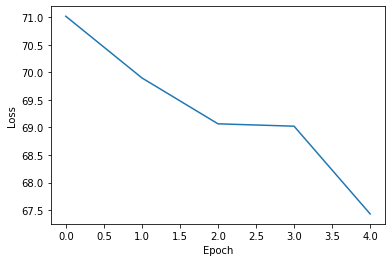

In [ ]:
#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
conv_model.load_weights("/content/CFD/conv_model.h5")

history = conv_model.fit(training_dataset, epochs=5, steps_per_epoch=train_batches,
          validation_data=validation_dataset, validation_steps=validation_batches, 
            callbacks=[tf.keras.callbacks.TensorBoard(log_dir='/tmp/conv')])

data_utils.plot_keras_loss(history)
# not much improvement after 20 epochs, takes 25sec/epoch on v100  

### Test
We will evaluate the model on the test dataset, and plot some of the results.

In [ ]:
test_loss = conv_model.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 89ms/step - loss: 55.3150
The loss over the test dataset 55.31496047973633


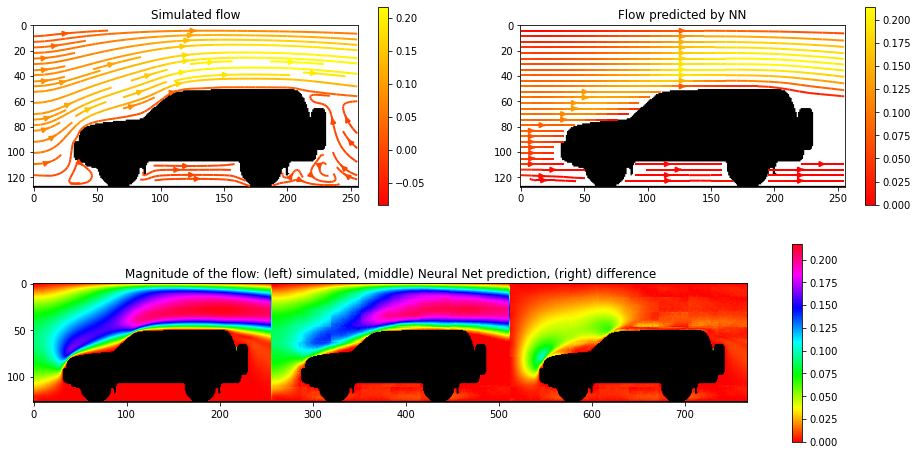

In [ ]:
x, y = data_utils.load_test_data(1) # You can try different values between 1 and 28
y_hat = conv_model.predict(x)
data_utils.plot_test_result(x, y, y_hat)

# Input Data Manipulation
## Use signed distance function as the input feature
To improve the performance of the model, we will use a different encoding of the input data. Instead of giving 0s and 1s, we calculate the signed distance function (SDF) of the input data.

Let  denote the set of points inside solid objects, and  its boundary. We define 
 as the distance between point 
 and the boundary .

 
The signed distance function is defined as

 
For every point in the grid, the SDF tells the distance to the closest boundary point. The plot below illustrates the SDF.

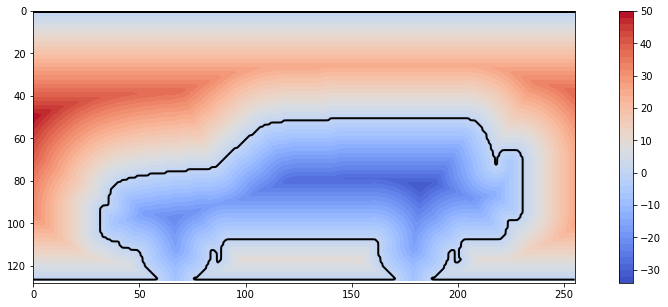

In [ ]:
data_utils.plot_sdf(x[:,:,:], plot_boundary=True)

In [ ]:
!cp -rf /content/CFD/data/test.tfrecords /content/data/test.tfrecords
!cp -rf /content/CFD/data/train.tfrecords /content/data/train.tfrecords

The following functions will create two new input files where the SDF is added as the second channel of the input data. Let it run for a minute.

In [ ]:
%%time 
data_utils.create_sdf_file('train')
data_utils.create_sdf_file('test')

100%|██████████| 28/28 [00:00<00:00, 55.42it/s]


CPU times: user 57.3 s, sys: 3.58 s, total: 1min
Wall time: 1min


Let's load our new dataset.

In [ ]:
batch_size = 8
dataset_size = 1500   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)

def init_sdf_datasets():
    # Set up a dataset
    sdf_dataset = tf.data.TFRecordDataset('data/train_sdf.tfrecords')
    sdf_dataset = sdf_dataset.take(dataset_size)
    # Transform binary data into image arrays
    sdf_dataset = sdf_dataset.map(data_utils.parse_sdf_flow_data) 

    sdf_training_dataset = sdf_dataset.skip(validation_size).shuffle(buffer_size=512)
    sdf_training_dataset = sdf_training_dataset.batch(batch_size, drop_remainder=True)
    sdf_training_dataset = sdf_training_dataset.repeat()

    sdf_validation_dataset = sdf_dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    sdf_validation_dataset = sdf_validation_dataset.repeat()

    # Read test dataset
    sdf_test_dataset = tf.data.TFRecordDataset('data/test_sdf.tfrecords')
    sdf_test_dataset = sdf_test_dataset.map(data_utils.parse_sdf_flow_data) # Transform binary data into image arrays
    sdf_test_dataset = sdf_test_dataset.batch(batch_size, drop_remainder = True).repeat()

    print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)
    return sdf_training_dataset,sdf_validation_dataset,sdf_test_dataset

We can visualize the the SDF for the training data :

Number of batches in train/validation/test dataset: 155 / 32 / 3
input shape: [8, 128, 256, 2]
output shape: [8, 128, 256, 2]


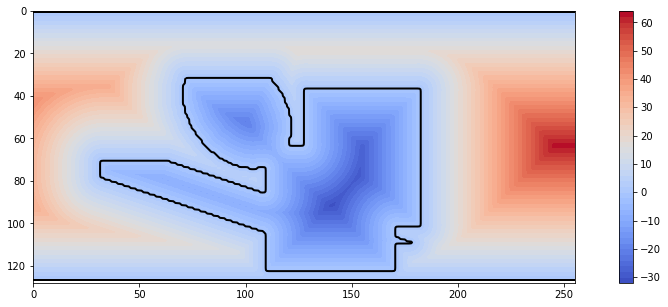

In [ ]:
sdf_training_dataset, sdf_validation_dataset, sdf_test_dataset = init_sdf_datasets()
# Create an iterator for reading a batch of input and output data
iterator = iter(sdf_training_dataset)
boundary, vflow = next(iterator)
boundary, vflow = next(iterator)

print('input shape:', boundary.shape.as_list())
print('output shape:', vflow.shape.as_list())

plot_idx = 2 # set it between 0 and batch_size

data_utils.plot_sdf(boundary[plot_idx,:,:,0],boundary[plot_idx,:,:,1])

We can notice above that now our input data has 2 Channel holding boundary data and signed distance function respectively.

We will use the boundary condition as a mask to remove flow lines in those areas. So, let's modify the the convolutional network model to use the new SDF input feature

In [ ]:
def conv_deconv_sdf(input):
    # Combine the convolution / deconvolution steps
    boundary = layers.Lambda(lambda x : x[:,:,:,0:1], name="boundary_slice")(input)
    sdf = layers.Lambda(lambda x : x[:,:,:,1:2], name="sdf_slice")(input)
    
    
    ### Calculate the encoding using the SDF
    x = conv(sdf)
    ###
    
    vx = deconv(x, "vx")
    
    # create a mask to zero out flow at (and inside) the boundary 
    vx = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vx')([vx, boundary])
    
    vy = deconv(x, "vy")
    vy = layers.Lambda(lambda x: x[0]*(1-x[1]), name='mask_vy')([vy, boundary])
    
    output = layers.concatenate([vx, vy], axis=3)
    
    return output

In [ ]:
K.clear_session()

# we need to re-init the dacaset because of Clearing our session
sdf_training_dataset, sdf_validation_dataset, sdf_test_dataset = init_sdf_datasets()

# Define Input Outputs and Train the Model
input = tf.keras.Input(shape=(128,256,2), name="boundary")
output = conv_deconv_sdf(input)
conv_sdf_model = tf.keras.Model(inputs = input, outputs=output)
conv_sdf_model.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
conv_sdf_model.summary()

Number of batches in train/validation/test dataset: 155 / 32 / 3
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 boundary (InputLayer)          [(None, 128, 256, 2  0           []                               
                                )]                                                                
                                                                                                  
 sdf_slice (Lambda)             (None, 128, 256, 1)  0           ['boundary[0][0]']               
                                                                                                  
 conv1 (Conv2D)                 (None, 8, 16, 128)   32896       ['sdf_slice[0][0]']              
                                                                                                  
 conv2 (Conv2D)              

Epoch 1/5
155/155 [==============================] - 37s 220ms/step - loss: 71.2652 - val_loss: 80.2121
Epoch 2/5
155/155 [==============================] - 34s 214ms/step - loss: 71.3024 - val_loss: 80.5991
Epoch 3/5
155/155 [==============================] - 34s 215ms/step - loss: 69.3098 - val_loss: 78.8134
Epoch 4/5
155/155 [==============================] - 34s 215ms/step - loss: 68.2177 - val_loss: 78.6769
Epoch 5/5
155/155 [==============================] - 34s 215ms/step - loss: 68.0891 - val_loss: 78.6923


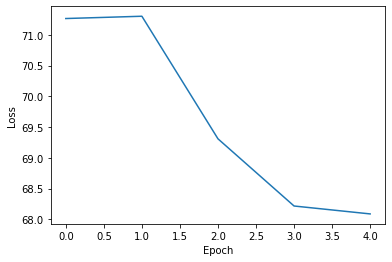

In [ ]:
#But Training our model from scratch will take a long time
#So we will load a partially trained model to speedup the process 
conv_sdf_model.load_weights("/content/CFD/conv_sdf_model.h5")

history = conv_sdf_model.fit(sdf_training_dataset, epochs=5, steps_per_epoch=train_batches,
          validation_data=sdf_validation_dataset, validation_steps=validation_batches)

# Plot Training data
data_utils.plot_keras_loss(history)

### Test

In [ ]:
test_loss = conv_sdf_model.evaluate(sdf_test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 86ms/step - loss: 53.3996
The loss over the test dataset 53.399600982666016


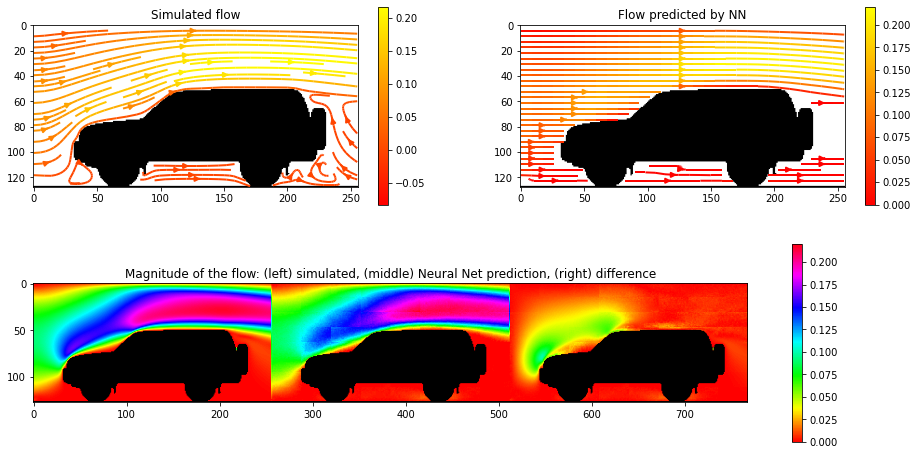

In [ ]:
x, y = data_utils.load_test_data(1) # You can try different values between 1 and 28
sdf = np.reshape(data_utils.calc_sdf(x[0,:,:,0]),(1,x.shape[1], x.shape[2],1))
x = np.concatenate((x, sdf), axis=3)
y_hat = conv_sdf_model.predict(x)
data_utils.plot_test_result(x[:,:,:,0:1], y, y_hat)

We find the Signed distance function performed better than the Boundary defined input. Let us understand why this is the case:

From the Research paper :

Geometry can be represented in multiple ways, such as boundaries and geometric parameters. However, those               representations are not effective for neural networks since the vectors' semantic meaning varies.
The values of SDF on the sampled Cartesian grid not only provide local geometry details but also contain additional     information of the global geometry structure.
To put the above in simple words, when our Convolution neural networks learn, we have seen that it also convolutes over an area of the set kernel size where it takes the considerations of the neighbouring pixels and not just a single pixel, this makes the signed distance function a rightful choice as it assigns values to all the pixels in the input image.

In the upcoming notebook, let us introduce some advance networks and train them.

# Part IV

Let us import libraries, dataset and define the Loss Function

# reset RUNTIME on colab

In [ ]:
# Import Necessary Libraries
from __future__ import print_function

import sys
sys.path.append('/content/CFD/source_code')

import numpy as np 
import time
import importlib
import os
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

# Custom Utlities
import model.flow_architecture as flow_architecture
import utils.data_utils as data_utils

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

2.7.0


In [ ]:
batch_size = 8
dataset_size = 2000   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('CFD/data/train.tfrecords')
    dataset = dataset.take(dataset_size)
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)
    
    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('CFD/data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True)
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 218 / 32 / 3


In [ ]:
def loss_image(vflow_hat, vflow):
    ''' Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    '''
    ### Define the square error loss (~ 1 line of code)
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

## Advanced network
In this section we will use the model by O. Hennigh

### Model ( Non- Gated Residual Block )
The network architecture in inspired by the U-net, additionally it uses gated residual blocks. 

Kindly refer here to know more about Residual Networks and Residual Blocks

Let's start building the architecture step-by-step :

We will need to build the flow of our network as follows :



Now, if we try to model this U-Network into one cell of the notebook, it will become extremely long and hard to add/remove the depth of the layers. So, let us see if we can break this into modular functions.



We will now start building each block one by one :

### Let us now Define our Activation Function :
We will be using a custom Activation Function for this, we will be using concatenated ELU :



Concatenated ELU : We take both the +ve and -ve values and apply ELU Activation Functions on it.

###Why we need to create a custom activation function for our model?
 The answer is because we want to preserves both positive and negative phase information while enforcing non-saturated non-linearity.

Let's define the helper function to switch between different activation functions after which we will build the Residual Block.

In [ ]:
def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1    # Dimensions of the data subtracted by 1 
    return elu(concatenate([x, -x], axis=axis)) # Concatenated x and -x of the Data and Apply ELU on it 

In [ ]:
# Helper Function to Set Non-linearity
def set_nonlinearity(name):
    if name == 'concat_elu':
        return concat_elu
    elif name == 'elu':
        return tf.nn.elu
    elif name == 'concat_relu':
        return tf.nn.crelu
    elif name == 'relu':
        return tf.nn.relu
    else:
        raise('nonlinearity ' + name + ' is not supported')

In [ ]:
def res_block(x, a=None, filter_size=16, nonlinearity=concat_elu, rate=0, stride=1, gated=False, name="resnet"):
    """ Residual block of 3x3 convolutions """
    # Copy of our Input
    orig_x = x
    # Get Shape of Input data
    orig_x_int_shape = flow_architecture.int_shape(x)
    
    #### First Convolution Layer
    # If Input has one channel Data ( i.e., Input is our Input Image )
    if orig_x_int_shape[3] == 1:
        x_1 = flow_architecture.conv_layer(x, 3, stride, filter_size, name + '_conv_1')
    else:
        x_1 = flow_architecture.conv_layer(nonlinearity(x), 3, stride, filter_size, name + '_conv_1')
    
    # a is fed during the Up-sampling part of the Network ( Refer Upsampling block )
    if a is not None:
        shape_a = flow_architecture.int_shape(a)
        shape_x_1 = flow_architecture.int_shape(x_1)
        paddings = [[0,0],[0, shape_x_1[1]-shape_a[1]], [0, shape_x_1[2]-shape_a[2]], [0, 0]]
        a = tf.pad(a, paddings)
        x_1 = x_1 + flow_architecture.nin(nonlinearity(a), filter_size, name + '_nin')
    # Add Activation Function and Dropout
    x_1 = nonlinearity(x_1)
    x_1 = Dropout(rate=rate)(x_1)
    
    #### Second Convolution Layer 
    # Implemented Gated Residual Blocks 
    if not gated:
        x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size, name + '_conv_2')
    else:
        x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size*2, name + '_conv_2')
        x_2_1, x_2_2 = tf.split(axis=3,num_or_size_splits=2,value=x_2)
        x_2 = x_2_1 * tf.nn.sigmoid(x_2_2)
    
    # During Down-sampling Apply Pooling layer for the Input to Match the Outout
    if int(orig_x.get_shape()[2]) > int(x_2.get_shape()[2]):
        orig_x = tf.nn.avg_pool(orig_x, [1,2,2,1], [1,2,2,1], padding='SAME')

    # Pad Input Data
    out_filter = filter_size
    in_filter = int(orig_x.get_shape()[3])
    if out_filter != in_filter:
        orig_x = tf.pad( orig_x, [[0, 0], [0, 0], [0, 0], [(out_filter-in_filter), 0]])
    # Output Input Data + Output of Convolution Layer ( Why ? Because this is a Residual Block )
    return orig_x + x_2

### Let's now build the Downsampling Function and Upsampling Functions

In [ ]:
def downsampling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated,name_prefix, downsample):
    ''' An optional downsampling step followed by one (or more) residual blocks '''
    
    # Set Parameters and Call our Residual Block Function 
    if downsample:
        x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, stride=2,gated=gated, name=name_prefix + "downsample")
    for i in range(nr_res_blocks):
        x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, stride=1,rate=rate, gated=gated, name=name_prefix + str(i))      
    return x   

In [ ]:
def upsumpling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, 
                        name_prefix, a):
    ''' Upsampling followed by a residual block '''
    # Set Parameters and Call our Residual Block Functions
    x = flow_architecture.transpose_conv_layer(x, 3, 2, filter_size, name_prefix)
    for i in range(nr_res_blocks):
        if i == 0:
            x = res_block(x, a, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, gated=gated, name=name_prefix + str(i))
        else:
            x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, gated=gated, name=name_prefix + str(i))

    return x

### Let's now build the functions where we set our parameters

In [ ]:
def conv_res(inputs, nr_res_blocks=1, rate=1.0, nonlinearity_name='concat_elu', gated=True):
    """Builds conv part of net.
    Args:
      inputs: input images
      rate: dropout layer
    """
    # Set Non-linearity
    nonlinearity = set_nonlinearity(nonlinearity_name)
    filter_size = 8
    # Store for Concatenation of the Downsampling output with the Upsampling blocks
    a = []
    
    # First Downsampling Residual Block to Convert Input Image from ( 128  ,256 ,1 ) to ( 128 , 256 , 8)
    
    x = downsampling_res_blocks(inputs, nr_res_blocks, filter_size, nonlinearity, rate, gated, "resnet_1_", False)
    
    # Loop Through Downsampling Blocks 
    for i in range(2,6):
        a.append(x)
        filter_size = 2 * filter_size
        name_prefix = "resnet" + str(i) + "_"
        x = downsampling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, name_prefix, True)

    # Loop Through Up-sampling Blocks 
    for i in range(1,5):
        filter_size = int(filter_size /2)
        name_prefix = "up_conv_" + str(i)
        x = upsumpling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, name_prefix, a[-i])
    
    # Last Convolution Layer with Activation 
    x = flow_architecture.conv_layer(x, 3, 1, 2, "last_conv")
    x = tf.nn.tanh(x)

    return x

In [ ]:
def model(boundary, rate,gated=True):
    return conv_res(boundary, nr_res_blocks=1, rate=rate, nonlinearity_name='concat_elu', gated=gated)

In [ ]:
# Define Dropout Rate and Set Gated = False
rate = 0.3
gated = False

# Compile the Model
input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = model(input,rate=rate,gated=gated)
unet = tf.keras.Model(inputs = input, outputs=output)
unet.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
unet.summary()

In [ ]:
# Let's train our Model for 15 Epochs
results = unet.fit(training_dataset, epochs=15)
# it takes 40 sec per epoches 

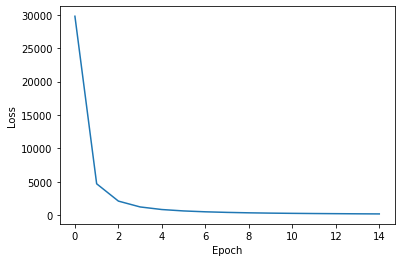

In [ ]:
# Let us Plot the train History
data_utils.plot_keras_loss(results)

### Let's Test our Model

In [ ]:
test_loss = unet.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 1s 59ms/step - loss: 89.3241
The loss over the test dataset 89.32405853271484


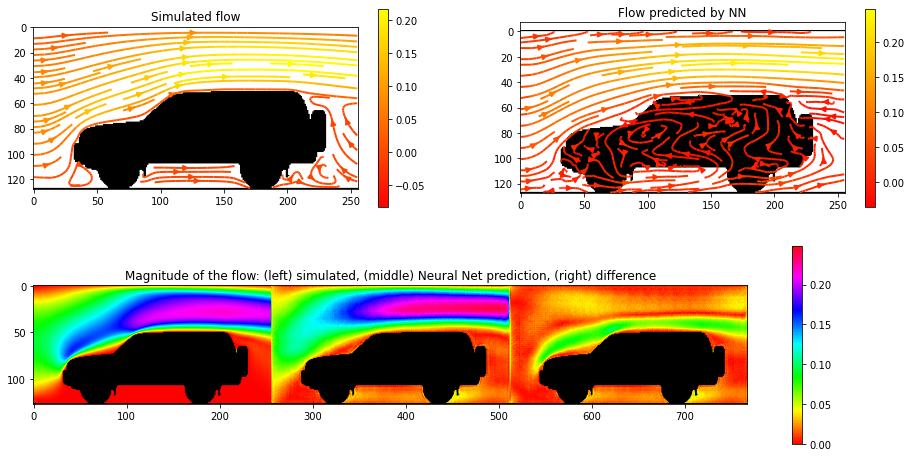

In [ ]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = unet.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

### Before we go ahead to train further models, let us understand why this network performed better :
U-networks were first used in Biomedical Image Segmentations. The research papers suggest the following :

However, in many visual tasks, especially in biomedical image processing, the desired output should include localization, i.e., a class label is supposed to be assigned to each pixel. Moreover, thousands of training images are usually beyond reach in biomedical tasks
This is very similar to our Problem because :

We have a limited dataset as creating an extensive database is computationally expensive in the case of Fluid Dynamics.
Just like a class label needs to be assigned for the Biomedical Applications, we need numerical values to be assigned with every pixel to predict the flow around the objects.
## Gated Residual Blocks
For using Gated residual blocks, we will have to change the variable gated = False to gated = True.

But What is Residual Gates ??

Residual Gates leverages the idea of shortcut connections but with a simple weighted linear combination between the original layer’s output and input. This improves the learning capacity of the Residual Blocks.

How do we implement it?

x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size*2, name + '_conv_2')  # Convolution Operation 
x_2_1, x_2_2 = tf.split(axis=3,num_or_size_splits=2,value=x_2)                  # Splitting Layers
x_2 = x_2_1 * tf.nn.sigmoid(x_2_2)                                              # Applying Sigmoid Activation as Weights

In [ ]:
K.clear_session()

# Define Dropout Rate and Set Gated = True 
rate = 0.3
gated = True

# we need to re-init the dacaset because of Clearing our session
training_dataset, validation_dataset, test_dataset = init_datasets()

input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = model(input,rate=rate,gated=gated)
unet = tf.keras.Model(inputs = input, outputs=output)
unet.compile(tf.keras.optimizers.Adam(0.0001), loss=loss_image)
unet.summary()

In [ ]:
# Let's train our Model for 20 Epochs
results = unet.fit(training_dataset, epochs=15)

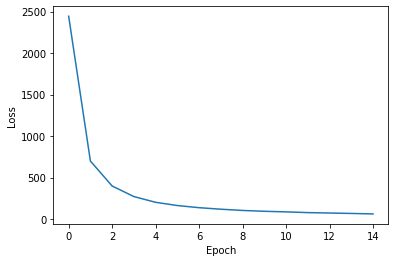

In [ ]:
# Let us Plot the train History
data_utils.plot_keras_loss(results)

### Let's Test our Model

In [ ]:
test_loss = unet.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 1s 57ms/step - loss: 15.3848
The loss over the test dataset 15.38482666015625


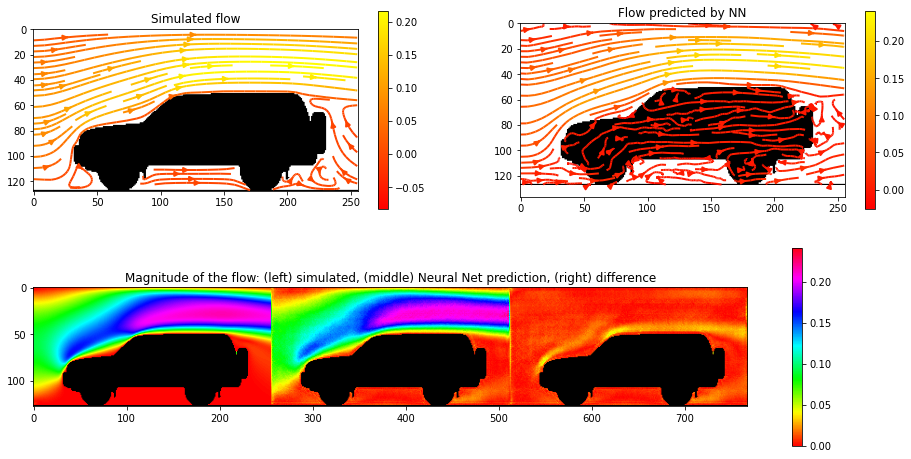

In [ ]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = unet.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)